# Multi-step ARIMA for COVID-19 Infections Forecast

In this notebook we try to forecast the number of cases of COVID 19 in the world using ARIMA. 

In the examples we try the method for the following scenarios:

- 1 day ahead
- 7 days ahead
- 30 days ahead

In [0]:
# https://machinelearningmastery.com/make-sample-forecasts-arima-python/
# https://machinelearningmastery.com/multi-step-time-series-forecasting/

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import timedelta
import itertools
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Defining the parameter search space

ARIMA has the following parameters:

p (lag order): number of lag observations included in the model

d (degree of differencing): number of times that the raw observations are differenced

q (order of moving average): size of the moving average window

In [3]:
# Shows how to generate all possibe combinations of parameters. Not used in the examples.
p = np.arange(0,11) 
d = np.arange(0,4)
q = np.arange(0,11)

configurations = list(itertools.product(p,d,q))
configurations.pop(0) # Remove configuration (0,0,0)
print(len(configurations))

483


## Get data

In [4]:
# CLone data repository
!git clone https://github.com/lrssv/TimeSeriesForecastingCOVID19 

# Get data
series = pd.read_csv('/content/TimeSeriesForecastingCOVID19/up_dataset_who.csv',header=0, parse_dates=[0], index_col=0, squeeze=True)

# The term bfill means that we use the value before filling in missing values
series = pd.Series(series.fillna(series.bfill()))

print(series)

fatal: destination path 'TimeSeriesForecastingCOVID19' already exists and is not an empty directory.
date_epicrv
2020-01-11 00:00:00+00:00       41
2020-01-12 00:00:00+00:00        0
2020-01-13 00:00:00+00:00        1
2020-01-14 00:00:00+00:00        1
2020-01-15 00:00:00+00:00        0
                             ...  
2020-04-30 00:00:00+00:00    72955
2020-05-01 00:00:00+00:00    85016
2020-05-02 00:00:00+00:00    90560
2020-05-03 00:00:00+00:00    84003
2020-05-04 00:00:00+00:00    86029
Name: cases, Length: 115, dtype: int64


## Experiments

- One day ahead
- One week ahead
- One month ahead

## Rolling forecast script

In [0]:
def run_tests(series,cold_start=30,steps_ahead=1,configurations=[(1,1,1)]):

  begin = series.index.min() + timedelta(days=0)
  # List of all dates from begin + cold_start to end
  date_list = [begin + timedelta(days=cold_start) + timedelta(days=x) for x in range(len(series)-steps_ahead-cold_start)]


  results = []
  ex_count = 0
  for c in configurations:
    for date in tqdm(date_list):
      # Select data
      train = series[begin:date] 

      f_date = date + timedelta(days=steps_ahead) # The day we want the forecast for

      # Fit ARIMA
      try: # Try to use ARIMA
        mod = sm.tsa.statespace.SARIMAX(train, order=c) # Selected the parameters randomly
        res = mod.fit(disp=False)
        # Get forecast
        forecast = res.forecast(days=steps_ahead)[0] 
        results.append([f_date,forecast,series[f_date],np.abs(series[f_date]-res.forecast()[0]),'arima',c])
      except: # Use persistence
        results.append([f_date,series[date],series[f_date],np.abs(series[f_date]-series[date]),'persistence',None])
        ex_count = ex_count+1


  print('ARIMA ERRORS: ' + str(ex_count))

  return results

In [0]:
def plot_results(series,results,steps_ahead):

  plt.rcParams.update({'font.size': 15})
  figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

  dates = [r[0] for r in results]
  error = [r[3] for r in results]
  forecasts = [r[1] for r in results]

  persist = [series[d + timedelta(days=-steps_ahead)] for d in dates]

  plt.plot(dates,error,'--')
  plt.plot(series,'-')
  plt.plot(dates,forecasts,'.')
  plt.plot(dates,persist,'-')
  
  plt.legend(['Error','Observed','Forecast','Persist'])


  print('MAE: {} ESTD: {}'.format(np.mean(error),np.std(error)))

In [0]:
def plot_error(series,results,steps_ahead):
  plt.rcParams.update({'font.size': 15})
  figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

  dates = [r[0] for r in results]
  error = [r[3] for r in results]
  forecasts = [r[1] for r in results]

  persist = [series[d + timedelta(days=-steps_ahead)] for d in dates]
  error_persist = [np.abs(series[d] - p) for d,p in zip(dates,persist)] 

  plt.plot(dates,error,'--')
  plt.plot(dates,error_persist,'--')
  plt.plot(series,'-')
  
  plt.legend(['Model Error','Persistence Error','Series'])


  print('Model MAE: {} Model ESTD: {}'.format(np.mean(error),np.std(error)))
  print('Persistence MAE: {} Persistence ESTD: {}'.format(np.mean(error_persist),np.std(error_persist)))


In [0]:
# Experimental setup

cold_start = 30 
configurations = [(7,1,7)] #ARIMA configuration. Comment this line to try all possible configurations.

## One day ahead

In [9]:
results_one_day_ahead = run_tests(series,cold_start=cold_start,steps_ahead=1,configurations=configurations)

  0%|          | 0/84 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No freq

ARIMA ERRORS: 6


MAE: 6399.986107439046 ESTD: 7778.972858059864


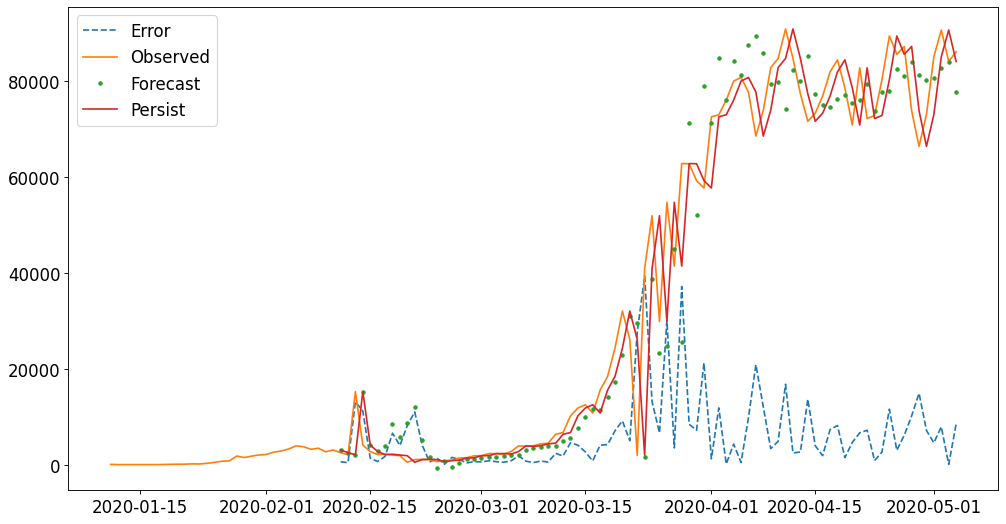

In [10]:
plot_results(series,results_one_day_ahead,1)

Model MAE: 6399.986107439046 Model ESTD: 7778.972858059864
Persistence MAE: 5166.083333333333 Persistence ESTD: 6798.233440366858


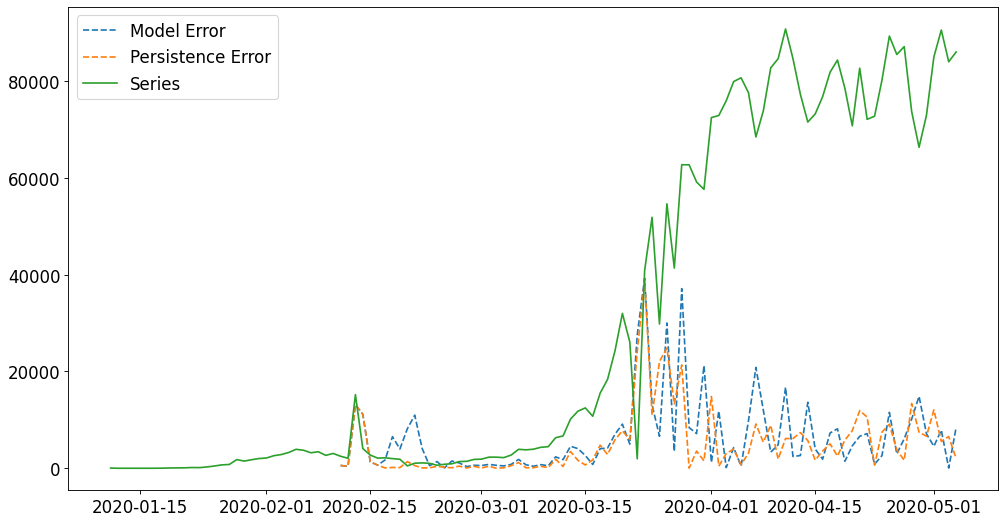

In [11]:
plot_error(series,results_one_day_ahead,1)

## 7 days ahead 

In [12]:
results_seven = run_tests(series,cold_start=cold_start,steps_ahead=7,configurations=configurations)

  0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No freq

ARIMA ERRORS: 6


MAE: 10670.110449221003 ESTD: 12247.933735883254


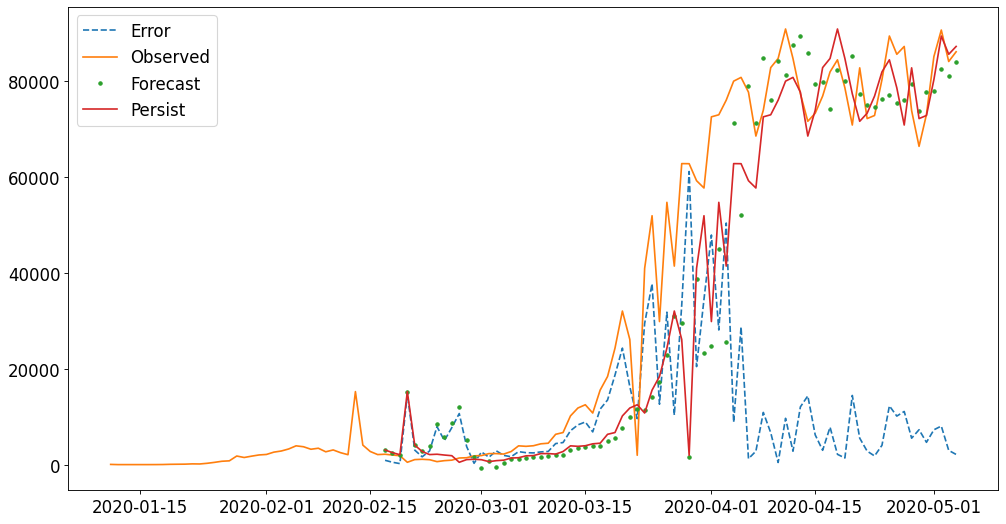

In [13]:
plot_results(series,results_seven,7)

Model MAE: 10670.110449221003 Model ESTD: 12247.933735883254
Persistence MAE: 9039.089743589744 Persistence ESTD: 11221.992874783413


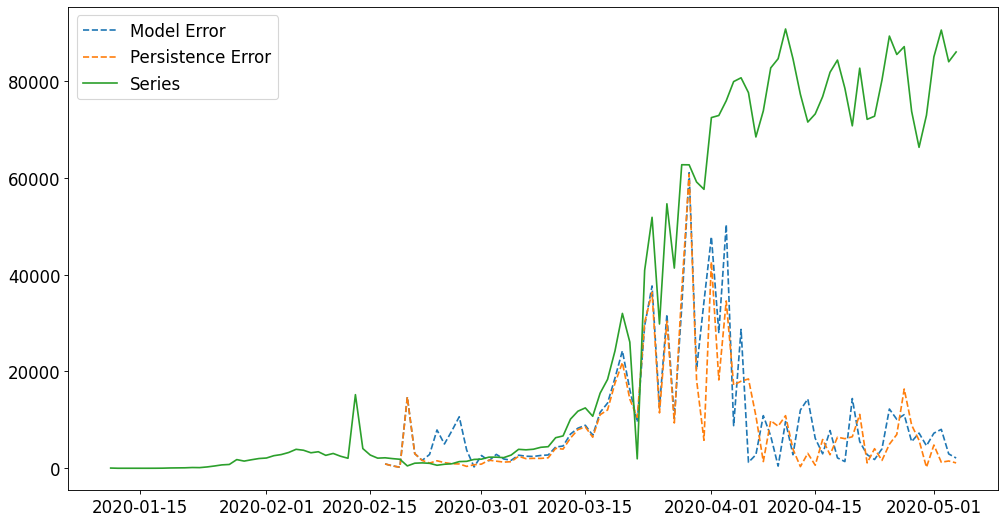

In [14]:
plot_error(series,results_seven,7)

## 30 days ahead

In [15]:
results_thirty = run_tests(series,cold_start=cold_start,steps_ahead=30,configurations=configurations)

  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No freq

ARIMA ERRORS: 6


MAE: 42431.610156209324 ESTD: 27694.88253244024


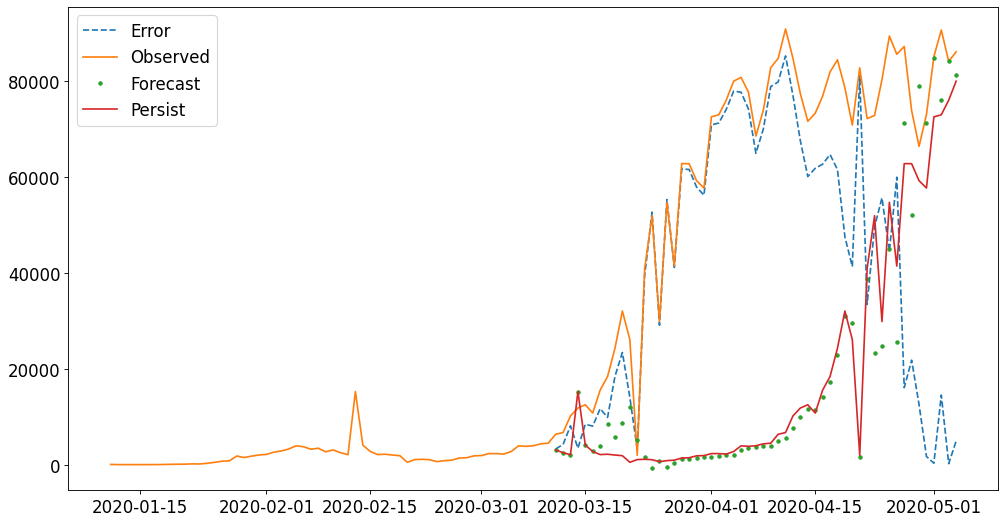

In [16]:
plot_results(series,results_thirty,30)

Model MAE: 42431.610156209324 Model ESTD: 27694.88253244024
Persistence MAE: 42049.05454545454 Persistence ESTD: 26258.272821007846


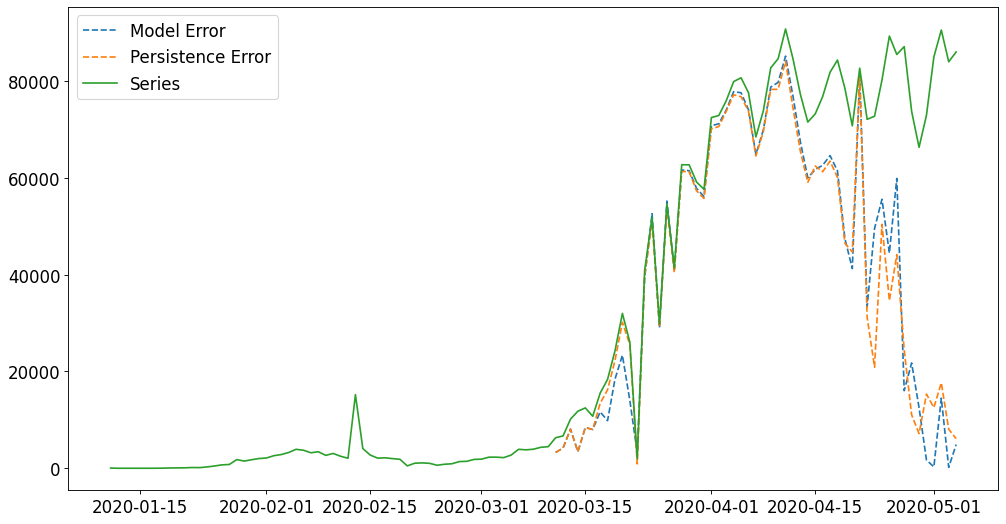

In [17]:
plot_error(series,results_thirty,30)